In [1]:
import itertools
import os
import pickle as pkl
from typing import List, Dict, Any

import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.datasets import fetch_openml

%load_ext autoreload
%autoreload 2

# change working directory to project root
if os.getcwd().split('/')[-1] != 'imodels':
    os.chdir('..')

MODEL_COMPARISON_PATH = 'tests/comparison_data/'

In [2]:
datasets = [
        ("breast-cancer", 13),
        ("breast-w", 15),
        ("credit-g", 31),
        ("haberman", 43),
        ("heart", 1574),
        ("labor", 4),
        ("vote", 56),
    ]

def get_comparison_result(path, estimator_name, test=False):
    if test:
        result_file = path + 'test/' + f'{estimator_name}_test_comparisons.pkl'
    else:
        result_file = path + 'val/' + f'{estimator_name}_comparisons.pkl'
    return pkl.load(open(result_file, 'rb'))

def viz_comparison(result: Dict[str, Any]):
    '''Plot ROC AUC vs complexity, including zoomed-in plot of overlapping region
    '''
    mean_result = result['df']['mean']
    result_estimators = result['estimators']
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
    for est in np.unique(result_estimators):
        
        est_result_df = mean_result[mean_result.index.str.contains(est)]
        complexities = est_result_df[est_result_df.index.str.contains('complexity')]
        rocs = est_result_df[est_result_df.index.str.contains('ROC')]
        complexity_sort_indices = complexities.argsort()    
        axes[0].plot(complexities[complexity_sort_indices], rocs[complexity_sort_indices], label=est.replace('_', ' '))
        
        if est in result['auc_of_auc'].index:
            area = result['auc_of_auc'][est]
            label = est.split(' - ')[1] + f' AUC: {area:.3f}'
            axes[1].plot(complexities[complexity_sort_indices], rocs[complexity_sort_indices], label=label.replace('_', ' '))

    for ax in axes:
        ax.set_xlabel('Complexity score')
        ax.set_ylabel('Average ROC AUC across comparison datasets')
        ax.legend(frameon=False, handlelength=1) 
    axes[1].set_xlim(result['auc_of_auc_lb'], result['auc_of_auc_ub'])
    axes[1].set_title('Overlapping, low (<30) complexity region only')
    
    plt.tight_layout()
    plt.show()

def viz_comparison_test(results: List[Dict[str, Any]]):
    plt.figure(dpi=250)
    for result in results:
        mean_result = result['df']['mean']
        est = result['estimators'][0]
        complexities = mean_result[mean_result.index.str.contains('complexity')]
        rocs = mean_result[mean_result.index.str.contains('ROC')]
        complexity_sort_indices = complexities.argsort()  
        plt.plot(complexities[complexity_sort_indices], rocs[complexity_sort_indices], label=est.replace('_', ' '))
    plt.xlim(0, 30)
    plt.xlabel('Complexity score')
    plt.ylabel('Average ROC AUC across comparison datasets')
    plt.legend(frameon=False, handlelength=1)
    plt.show()

# dataset stats

In [3]:
metadata = []
columns = ['name', 'samples', 'features', 'class 0 ct', 'class 1 ct', 'majority class %']
for dataset_name, data_id in datasets:
    dataset = fetch_openml(data_id=data_id, as_frame=False)
    shape = dataset.data.shape
    class_counts = np.unique(dataset.target, return_counts=True)[1]
    metadata.append([dataset_name, shape[0], shape[1], class_counts[0], class_counts[1], np.max(class_counts) / np.sum(class_counts)])
pd.DataFrame(metadata, columns=columns).set_index('name') 

,samples,features,class 0 ct,class 1 ct,majority class %
name,,,,,
breast-cancer,286,9,201,85,0.702797
breast-w,699,9,458,241,0.655222
credit-g,1000,20,300,700,0.700000
haberman,306,3,225,81,0.735294
heart,270,13,150,120,0.555556
labor,57,16,20,37,0.649123
vote,435,16,267,168,0.613793


# complexity vs. ROC Area plot for all models

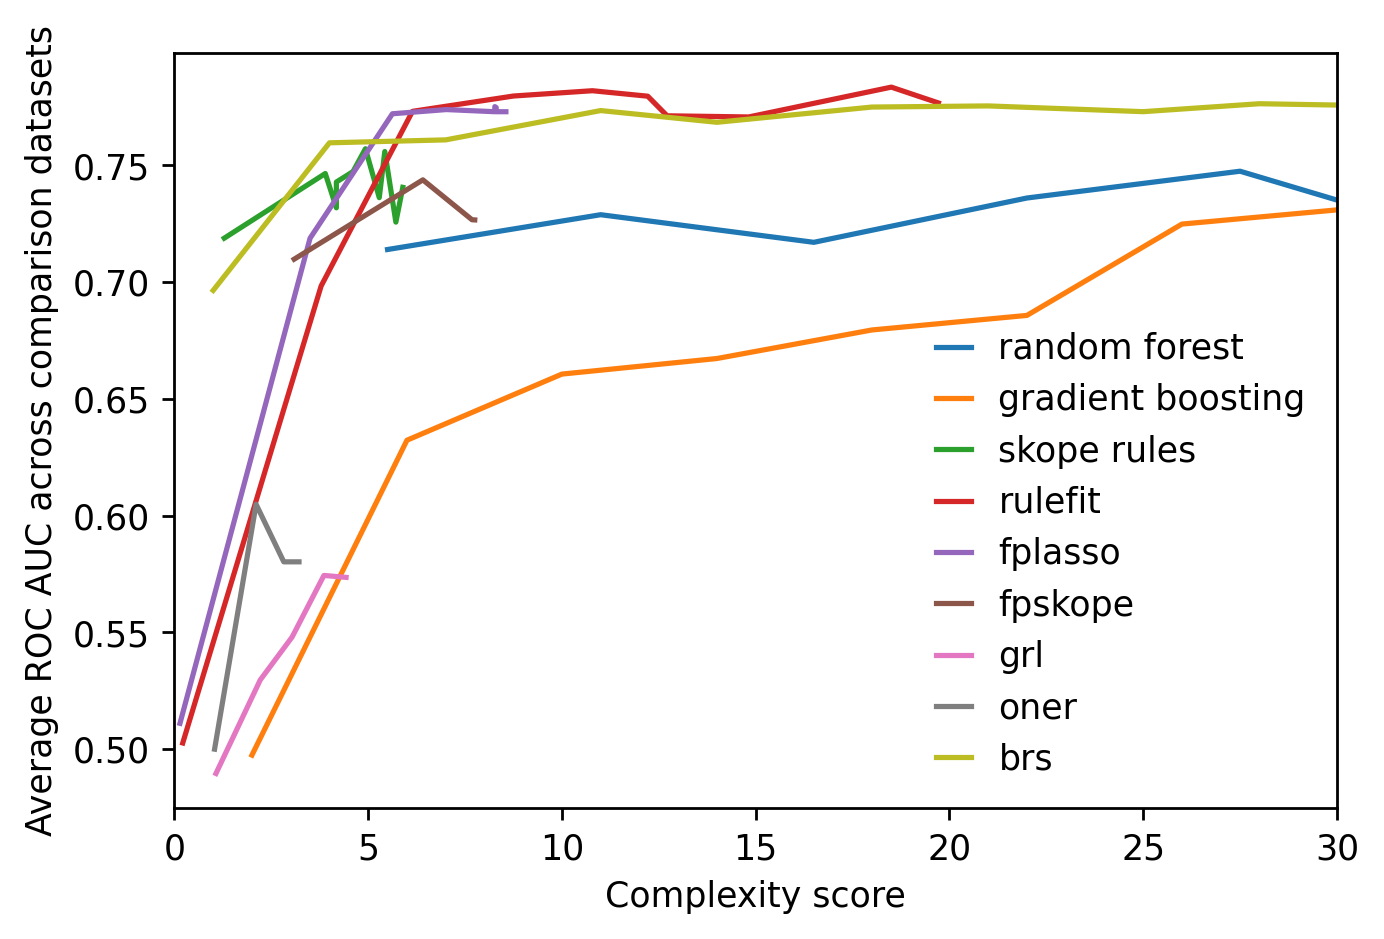

In [4]:
test_models = [
    'random_forest', 
    'gradient_boosting', 
    'skope_rules', 
    'rulefit', 
    'fplasso', 
    'fpskope',
    'grl',
    'oner',
    'brs']
test_results = [get_comparison_result(MODEL_COMPARISON_PATH, mname, test=True) for mname in test_models]
viz_comparison_test(test_results)

# hyperparameter tuning plots for each model


## Random Forest

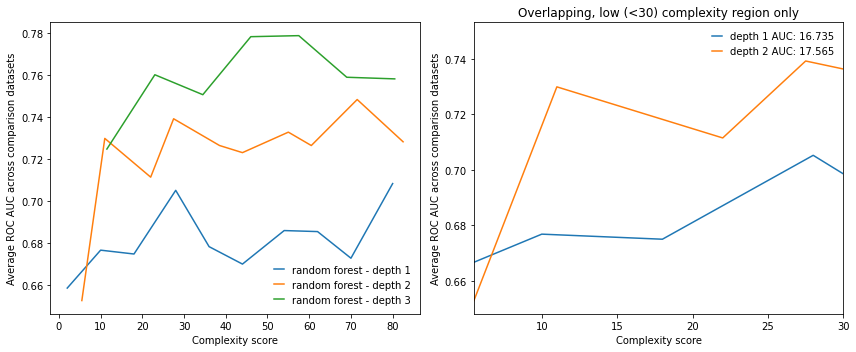

In [5]:
comparison_result = get_comparison_result(MODEL_COMPARISON_PATH, 'random_forest')
viz_comparison(comparison_result)

## Gradient boosted trees

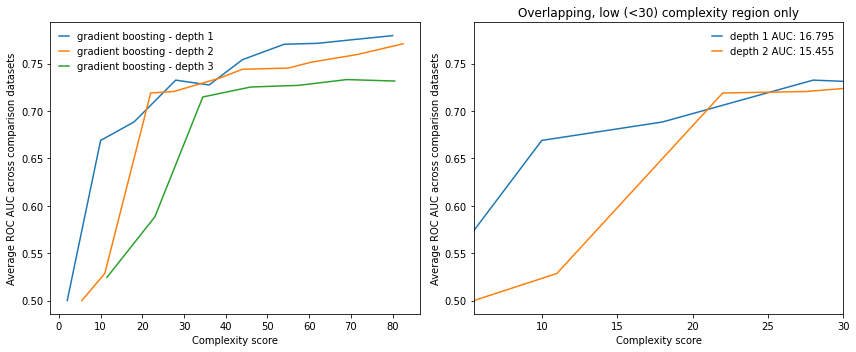

In [6]:
comparison_result = get_comparison_result(MODEL_COMPARISON_PATH, 'gradient_boosting')
viz_comparison(comparison_result)

## SkopeRules

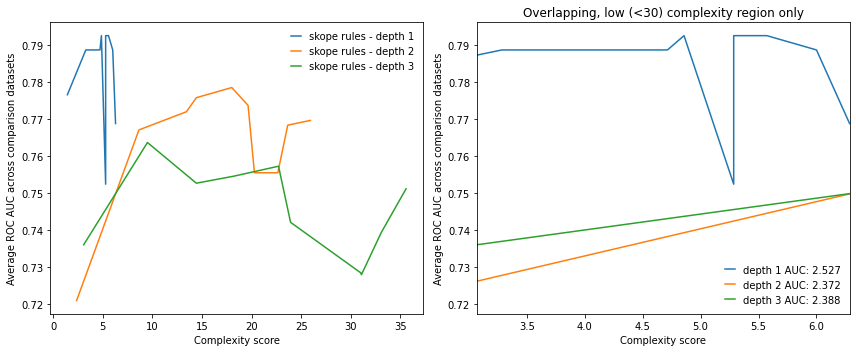

In [7]:
comparison_result = get_comparison_result(MODEL_COMPARISON_PATH, 'skope_rules')
viz_comparison(comparison_result)

## RuleFit

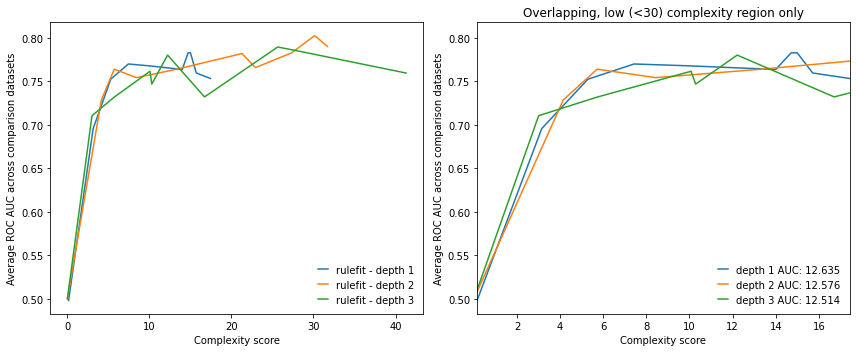

In [8]:
comparison_result = get_comparison_result(MODEL_COMPARISON_PATH, 'rulefit')
viz_comparison(comparison_result)

## FPLasso

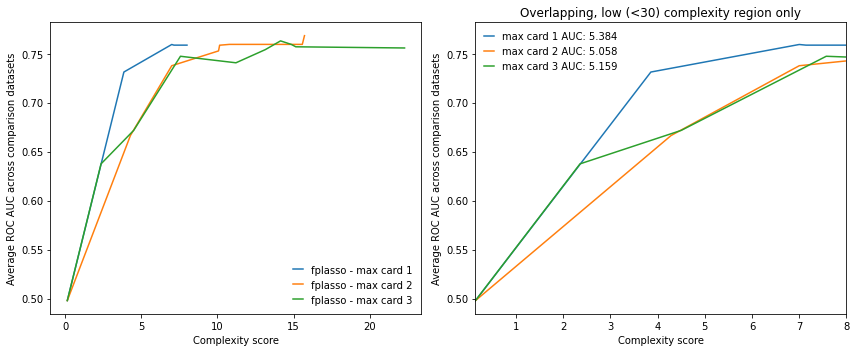

In [9]:
comparison_result = get_comparison_result(MODEL_COMPARISON_PATH, 'fplasso')
viz_comparison(comparison_result)

## FPSkope

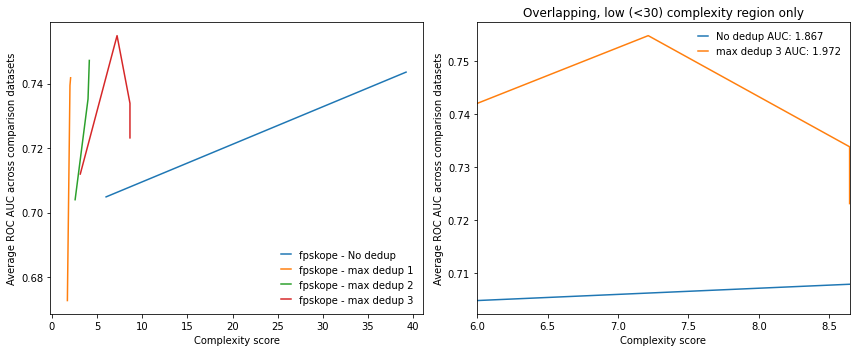

In [10]:
comparison_result = get_comparison_result(MODEL_COMPARISON_PATH, 'fpskope')
viz_comparison(comparison_result)

## BRL

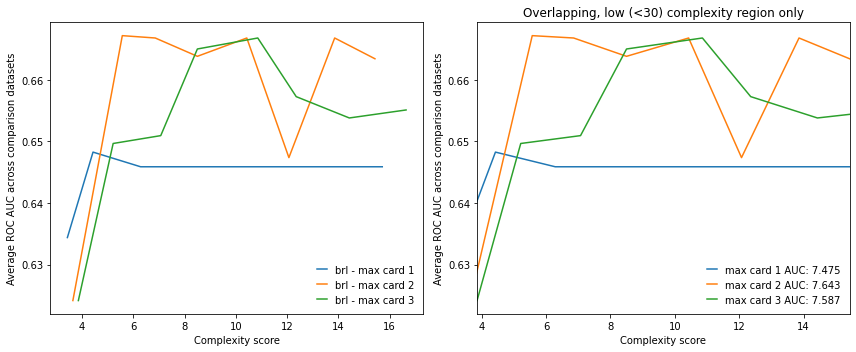

In [11]:
comparison_result = get_comparison_result(MODEL_COMPARISON_PATH, 'brl')
viz_comparison(comparison_result)